In [1]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn
import contextily
import os

DATA_DIR = r"C:\Users\Masat\デスクトップ_Instead\webアプリ開発\TIL\Statistics\Spatial Statistics\notebooks\data"

df = gpd.read_file(os.path.join(DATA_DIR, r"san_diego_airBnB\regression_db.geojson"))
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

df.head(3)

c:\Users\Masat\Anaconda3\envs\my-stan\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)


# Non-spatial regression, a (very) quick refresh

In [27]:
from pysal.model import spreg

# Fit OLS model
m1:spreg.ols.OLS = spreg.OLS(
    # Dependent variable
    y=df[["log_price"]].values,
    # Independent variables
    x=df[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

print(type(m1))
print(m1.summary)

<class 'spreg.ols.OLS'>
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------

## Hidden Structures

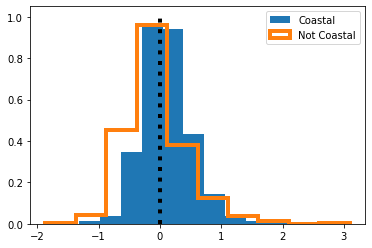

In [28]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = df.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

In [29]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

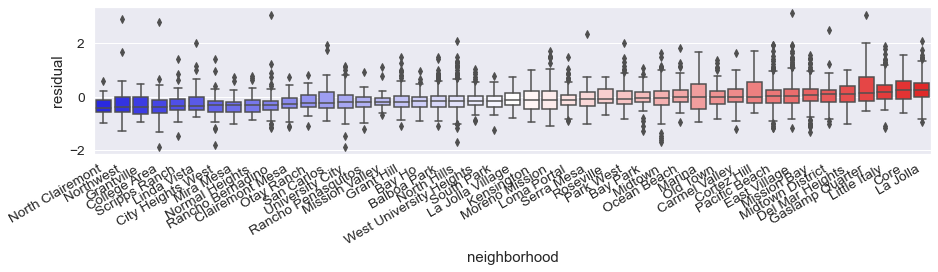

In [31]:
# Create column with residual values from m1
df["residual"] = m1.u
# Obtain the median value of residuals in each neighbourhood
medians = (
    df.groupby("neighborhood").residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighbourhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    "neighborhood",
    "residual",
    ax=ax,
    data=df.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    palette="bwr",
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

In [33]:
knn = weights.KNN.from_dataframe(df, k=1)

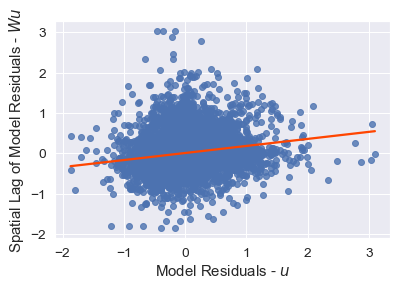

In [34]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

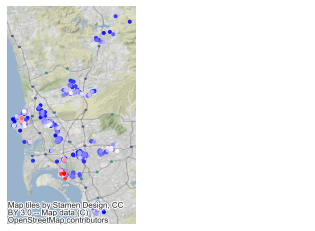

In [35]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    df.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=df.crs)
# Remove axes
ax.set_axis_off();

# Bringing space into the regression framework

## method 1: Spatial Feature Engineering: proximity variables

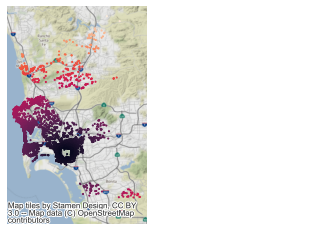

In [36]:
ax = df.plot("d2balboa", marker=".", s=5)
contextily.add_basemap(ax, crs=df.crs)
ax.set_axis_off();

In [37]:
balboa_names = variable_names + ["d2balboa"]

In [38]:

m2 = spreg.OLS(
    df[["log_price"]].values,
    df[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

pd.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


In [39]:
# Set up table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


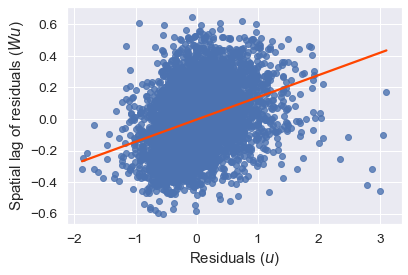

In [40]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    m2.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

## method 2: Spatial Heterogeneity

In [4]:
df['neighborhood'].head()

0    North Hills
1    Mission Bay
2    North Hills
3      Mira Mesa
4      Roseville
Name: neighborhood, dtype: object

- この文献では、一般に$alpha$の地理的な変動を「**Spatial Fixed Effects(空間固定効果)**」と呼んでいる。
- それを説明するために、前節の住宅価格の例で考えてみよう。
  - 空間固定効果は、結果が空間的に変化することを知っていて、それがどのようなパターン（我々の場合、近隣によって）であるかを知っていて、それに応じて$αla$を変化させることによって、その知識をモデルに取り入れることができるという意味で、「**space as a proxy(代理としての空間)**」を捉えると言われることがある。
  - その根拠は次のようなものである。
    - 我々がモデルにいくつかの説明変数しか含めていないことを考えると、家が売られる価格を決定する際に役割を果たすいくつかの重要な要因を見逃している可能性がある。
    - しかし、それらのいくつかは、**空間的に系統的に変化する**可能性が高い（例えば、異なる近隣特性）。
    - もしそうであれば、我々は、伝統的なバイナリ変数を使用し、その作成を空間的なルールに基づくことによって、それらの観察されない要因をコントロールすることができます。
    - たとえば、すべての近隣に対して、与えられた家がその地域内にあるかどうか（1）、または（0）を示すバイナリ変数を含めるとします。数学的には、我々は今、次の方程式に適合している。

$$
\log P_i =\alpha_r + \sum_{k}{X_{ik} \beta_{k}} + \epsilon_i
$$

ここで、主な違いは、定数項である$alpha$を近傍$r$で変化させること、$alpha_r$であることです。

プログラム的には、statsmodelsを使う方法と、spregを使う方法の2種類を紹介します。まず、Pythonの計量経済学ツールボックスであるstatsmodelsを使用します。

このパッケージは数式に似たAPIを提供し、推定したい方程式を直接表現することができる。

この文の**チルダ演算子**は、通常「log_price is a function of ...」と読みます。これは、log_priceと共変量リストの間の関数関係に従って、多くの異なるモデル仕様を適合させることができるという事実を説明するためです。
重要なのは、末尾の-1項が、切片項なしでこのモデルをフィットさせることを意味していることです。これは必要なことです。
なぜなら、すべての近隣地域に対して一意な平均と一緒に切片項を含めると、基礎となる方程式系が十分に規定されなくなるからです。

この式を用いて、statsmodelsでモデルをあてはめながら、各近隣の固有の効果を推定することができる（モデルの指定、式、データが、あてはめのステップと分離されていることに注意）。

In [7]:
df[variable_names].head()

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse
0,5,2.0,2.0,2.0,0,0,0,1,0,0
1,6,1.0,2.0,4.0,0,0,1,0,0,0
2,2,1.0,1.0,1.0,1,0,0,0,0,0
3,2,1.0,1.0,1.0,1,0,0,1,0,0
4,2,1.0,1.0,1.0,1,0,0,1,0,0


In [5]:
# Spatial Fixed Effects

import statsmodels.formula.api as sm
f = (
    "log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1" # カテゴリのカラムを追加してる => 各カテゴリ毎に独自のconstantを推定する??
)
print(f)

m3 = sm.ols(f, data=df).fit()

# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pd.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


上記のアプローチは、Spatial Fixed Effectがカテゴリ変数を用いた線形回帰の特殊なケースであることを示している。
Neighborhood membershipは、**バイナリダミー変数**を用いてモデル化されています。
statsmodelsで使用されている数式文法のおかげで、モデルを抽象的に表現することができ、Pythonはそれを解析し、必要に応じて適切にバイナリ変数を作成します。

=>neigborfood カラムのユニーク値分、バイナリダミー変数をstatsmodel側が自動で作成してくれている...!それを各地域毎のconstantとみなしている感じ...!

2つ目のアプローチは、spregのレジーム機能を利用するものである。レジームについては後述するが、ここでは空間固定効果の一般化として、$alpha$以外も変動することができると考える。このフレームワークでは、各グループで別々に推定される変数を指定することができます。この場合、モデルを数式で記述するのではなく、モデルの各要素を個別の引数として渡す必要があります。

In [8]:
from pysal.model import spreg


# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    y=df[["log_price"]].values,
    # Independent variables
    x=df[variable_names].values,
    # Variable specifying neighborhood membership
    regimes=df["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

import numpy as np

np.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.e+00,  4.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00, -1.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

計算されたすべての結果のレポートを印刷するには、上記と同様にsummary属性に依存します。ここでは簡単のために、推定されたパラメータが本当にstatsmodelsから得られたものと同じであることを小数点以下12桁まで確認することにします。

- 経済学的に言えば、今回導入したneighborhood Fixed Effectsは、サンディエゴ全体の住宅価格を等しく比較するのではなく、各郵便番号内の変動のみを導き出すことを意味する。
- このとき、$beta_k$の解釈は、含まれる他の説明変数がすべて一定である場合の変数$k$の効果であることを思い出してください。
- **各エリアについて単一の変数を含める**ことによって、我々は、各変数について同じ値を共有する住宅価格のみを等しいものとして比較するようにモデルを強制している、言い換えれば、同じエリア内にある住宅のみを比較しているのです。
- FEを導入することで、**導入したFEの分布と空間的に一致する観測されない効果をコントロールできる**ため、**モデルに導入した変数の効果をより高度に分離**することができます（この例では、地域ごとに）。


近隣固定効果マップを作成するためには、モデルの結果を少し修正する必要があります。

まず、近隣に関わる効果のみを抽出する。

In [10]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

次に、この Series のインデックスから近隣名のみを抽出する必要がある。これを行う簡単な方法は、近隣名称の前後にある文字をすべて取り除くことです。

In [11]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


よかった、生の近隣名称に戻りましたね。これで、同じ名前でインデックス化された、近隣の境界線を持つ補助的なファイルに結合することができます。まず、境界を読んでみましょう。

In [ ]:
sd_path = os.path.join(DATA_DIR, )
neighborhoods = geopandas.read_file(sd_path)

![](https://geographicdata.science/book/_images/11_regression_59_0.png)

SFEの推定値には、明確な空間的構造が見られる。
最も高価な地域は海岸近くに位置し、最も安価な地域はより内陸に位置する傾向がある。

## Spatial Regimes

- Spatial Fixed Effectの推定の核心は、**従属変数が空間的に一様な振る舞いをすると仮定するのではなく、その振る舞いに影響を与える地理的パターンに従った系統的効果が存在するという考え方**である。
  - 言い換えれば、Spatial FEはSpatial Heterogeneityという概念を経済学的に導入する。
  - これは、定数項を地理的に変化させるという、最も単純な形で行われる。
  - 回帰の他の要素はそのままで、それゆえ空間的に一様に適用される。
- 空間レジーム（SR）の考え方は、空間FEアプローチを一般化して、**定数項だけでなく、他の説明変数も変化させる**ことができるようにすることです。
- これは、これから推定する方程式を意味する。

$$
\log P_i = \alpha_r + \sum_{k}{X_{ki}\beta_{k-r}} + \epsilon_i
$$

ここで、定数項($\alpha_r$)だけでなく、他のすべてのパラメータも地域によって変化するようにする($\beta_{kr}$)。

このアプローチを説明するために、**家が沿岸地域にあるかどうか**という「Spatial Differentiator(空間的差別化要因)」（`coreast_neig`）を使って、レジームを定義することにする。
この選択の根拠は、海の近くに家を借りることは、人々が家の特性ごとに異なるレートで支払うことを望むほど強い引力であるかもしれないということである。

Pythonでこれを実装するために、spregのOLS_Regimesクラスを使用します。

In [12]:
df['coastal'].head()

0    0
1    1
2    0
3    0
4    0
Name: coastal, dtype: int64

In [13]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    y=df[["log_price"]].values,
    # Independent variables
    x=df[variable_names].values,
    # Variable specifying neighborhood membership
    regimes=df["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

この結果は、前のものと同様に探索し、解釈することができます。要約属性を調べると、各変数のパラメータは、両方のレジームにわたって、ほとんど期待されるものに適合していることがわかります。それらを比較するために、オーダーメイドの表で並べてプロットすることができます。

In [14]:
# Results table
res = pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pd.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pd.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pd.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

Regimes間の関連性については、興味深い問題がある。レジーム間の各変数の推定値は、統計的に異なるのでしょうか？このために、モデル・オブジェクトは、Chow検定と呼ばれるものを計算してくれます。これは、異なるレジームからの推定値が区別されないという帰無仮説を検定する統計量です。もし、帰無仮説を棄却すれば、我々は、レジームの違いが実際にあることを示唆する証拠を手に入れたことになります。

Chow検定の結果はsummary属性で見ることができますが、モデルオブジェクトから直接抽出することもできますので、ここではそれを行います。

Chow検定には2つのタイプがあります。1つは、2つのレジーム間の差異を共同で検定するグローバルなものです。

In [15]:
print(m5.chow.joint)

(328.869021430265, 7.11354876742171e-64)


最初の値は統計量を表し、2番目の値はp値を捉えている。この場合、2つのレジームは統計的に互いに異なっている。

chow検定の2つ目のタイプは、モデルの各係数がレジーム間で異なるかどうかをチェックする、ローカルなものである。このために、我々はそれらを表として引き出すことができる。

In [17]:
pd.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


表からわかるように、ほとんどの変数が、統計的にみて、確かにレジーム間で異なっている。これは、空間レジーム間のデータ生成過程の系統的な差異を指摘している。

# Spatial Dependence

- 先ほど説明したように、SH(Spatial Heterogeneity)は地理と明確に関連し、それゆえに空間的な変動や集積を引き起こす現象の効果についてである。
- これは、線形回帰をフィットするときに興味を持つかもしれない種類の空間効果の多くを包含しています。
- しかし、他のケースでは、我々の焦点は、オブザベーションの空間的配置の効果、およびそれが我々が検討している結果に影響を与える程度にあります。
  - 例えば、住宅の価格は、それがタウンハウスかアパートかに依存するだけでなく、その周囲がアパートの多い高層ビルよりも多くのタウンハウスに囲まれているかどうかにも依存すると考えることができる。
  - これは、高さの低い歴史的建造物が立ち並ぶ地域と、近代的な高層ビルが立ち並ぶ地域とでは、「外観や雰囲気」が異なることと関係があるのではないか、という仮説が成り立つ。
  - このような2つの異なる空間構成が住宅価格の決定過程にどの程度まで入り込んでくるかについては，住宅の特性だけでなく，その周辺の特性についても把握する必要がある。
- **この種の空間効果は，SHとは根本的に異なり，地形の固有の特性に関係するのではなく，我々のデータセットにおける観測値の特性，特にその空間的配置に関係するもの**である。
- 我々は，オブザベーションの値が距離を通してお互いに関係するこの現象を**Spatial Dependence**[Ans88]と呼ぶ．

計量経済学の枠組みで空間依存性を導入する方法はいくつかあり、計量経済学の洗練度は様々である（良い概要は[Ans02]を参照）。
しかし、それらに共通するのは、空間を形式的にカプセル化する方法であり、第4章で説明した空間重み行列（W）を通じて行う。
このセクションでは、空間重み行列を通して空間依存性を回帰のフレームワークに組み込むことができる3つの方法について考察する。
まず、独立変数のみを変更する「least invasive(最小侵襲)」の方法から始め、ベースライン線形モデルのより実質的な変更に移行する。

## Exogenous effects: The SLX Model 外生的な効果 SLXモデル

ここで、先ほどの住宅価格の例に戻ってみましょう。これまで、サンディエゴでAirBnBを通じて借りられる家の価格は、**その家自身の特性に関する情報と、近隣や市内の主要な公園までの距離といった立地に関する情報**を使って説明できると仮定してきました。
しかし、家を借りる人は、家そのものだけでなく、**その家がどのような隣人に囲まれているか**を気にし、特定のタイプの家に囲まれている家に対してはより多くのお金を払い、他のタイプの家の真ん中にある場合はあまり払わないと考えることも妥当であろう。
では、どうすればこの考えを検証できるのだろうか。

When it comes to regression, the most straightforward way to introduce spatial dependence between the observations in the data is by considering not only a given explanatory variable, but also its spatial lag. Conceptually, this approach falls more within the area of spatial feature engineering, which embeds space in a model through the explanatory variables it uses rather than the functional form of the model, and which we delve into with more detail in Chapter 12. But we think it is interesting to discuss it in this context for two reasons. 
- First, it provides “intellectual scaffolding” to learn the intuition of building spatial dependence into regression. 
- And second, because it also illustrates how many of the techniques we cover in Chapter 12 can be embedded in a regression model (and, by extension, in other predictive approaches).


回帰に関して言えば、データ中のオブザベーション間の空間依存性を導入する最も簡単な方法は、与えられた説明変数だけでなく、そのSpatial Lagも考慮することである。概念的には、このアプローチは、モデルの関数形式ではなく、使用する説明変数を通してモデルに空間を埋め込むSpatial Feature Engineeringの領域であり、第12章でより詳細に掘り下げています。
しかし、この文脈で議論するのは2つの理由で面白いと考えている。
- まず、Spatial Dependenceを回帰に組み込む直観を学ぶための「知的足場」を提供する。
- そして2つ目は、第12章で取り上げる多くのテクニックが、いかに回帰モデル（ひいては他の予測的アプローチ）に埋め込むことができるかを示してくれるからです。

In our example case, in addition to including a dummy for the type of house (pg_XXX), we can also include the spatial lag of each type of house. This addition implies we are also including as explanatory factor of the price of a given house the proportion neighboring houses in each type. Mathematically, this implies estimating the following model:

この例では，住宅タイプダミー（pg_XXX）に加えて，住宅タイプごとのSpatial Lagを含めることができる。このことは，ある住宅の価格の説明 要因として，各タイプの住宅が隣接している割合を含んでいることを意味する。数学的には，これは次のようなモデルを推定することを意味する。

$$
\log (P_i) = \alpha + \sum_{k=1}^{p}{X_{ij}\beta_{j}} 
+ \sum_{k=1}^{p}(\sum_{j=1}^{N} w_{ij} x_{jk})\gamma_{k} + \epsilon_i
$$

ここで、$\sum_{j=1}^{N} w_{ij} x_{jk}$はk番目の説明変数の空間ラグを表す。



また、これは、空間重み行列 $W$を用いて行列形式で次のように述べることができる。
$$
\log (P_i) = \alpha + X\beta + WX\gamma + \epsilon
$$

This splits the model to focus on two main effects: $\beta$ and $\gamma$. 
The $\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. 
The subscript for site $i$ is important here: since we’re dealing with a $W$ matrix, it’s useful to be clear about where the change occurs.

これにより、モデルは$beta$と$gamma$の2つの効果に分割された。この$\beta$は、$X_{ik}$が1つ変化したときの$y_i$の変化を記述するものです。
ここで、サイト$i$の添え字が重要です。
$W$行列を扱っているので、どこで変化が起こるかを明確にすることが有効です。

Indeed, this matters for the $\gamma$ effect, which represents the indirect association of a change in $X_i$ with the house price. This can be conceptualized in two ways. First, one could think of $\gamma$ as simply the association between the price in a given house and a unit change in its average surroundings. This is useful and simple. 
But this interpretation blurs where this change might occur. In truth, a change in a variable at site $i$ will result in a spillover to its surroundings: 
when $x_i$ changes, so too does the spatial lag of any site near $i$. 
The precise size of the change in the lag will depend on the structure of $W$, and can be different for every site it is connected with. For example, think of a very highly-connected “focal” site in a row-standardized weight matrix. 
This focal site will not be strongly affected if a neighbor changes by a single unit, since each site only contributes a small amount to the lag at the focal site. 
Alternatively, consider a site with only one neighbor: its lag will change by exactly the amount its sole neighbor changes. 
Thus, to discover the exact indirect effect of a change $y$ caused by the change at a specific site $x_i$ you would need to compute the change in the spatial lag, and then use that as your change in $X$. 
We will discuss this in the following section.

- これは，$X_i$の変化と住宅価格との間接的な関連性を表す$gamma$効果にとって重要である。
- これは，2つの方法で概念化することができる。
- まず，$X_i$の変化と住宅価格との間接的な関連性を表す$Xgamma$効果である。これは便利で単純である。
- しかし、この解釈は、この変化がどこで起こるかをぼやかしてしまう。
- 本当は、サイト $i$ での変数の変化は、その周囲に波及することになる。
- x_i$が変化すると、$i$に近いサイトの空間ラグも変化する。
- ラグがどの程度変化するかは、$W$の構造に依存し、接続するサイトごとに異なる可能性があります。
- 例えば、行標準化ウェイト行列において、非常に高い結合度を持つ「焦点」サイトを考えてみよう。
- 各サイトは焦点サイトのラグに少量しか寄与しないので、近傍サイトが1単位で変化しても、この焦点サイトは強く影響されない。
- 一方、隣人が1人しかいないサイトを考えてみましょう。
- そのサイトのラグは、その唯一の隣人が変化した量だけ変化します。
- したがって、**特定のサイト$x_i$の変化によって引き起こされる変化$y$の正確な間接効果**を発見するためには、空間的な遅れの変化を計算し、それを$X$の変化として使う必要があります。
- これについては、次節で述べる。

Pythonでは、まず`pg_`で始まる名前を持つすべての変数のリストを作成し、それらに`pysal`の`lag_spatial`を適用することで、それぞれの変数のSpatial Lagを計算することができます。

In [22]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'neighborhood', 'pool',
       'd2balboa', 'coastal', 'price', 'log_price', 'id', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room', 'geometry'],
      dtype='object')

In [37]:
weight_matrix_knn = weights.KNN.from_dataframe(df, k=20)

# Select only columns in `db` containing the keyword `pg_`
df_temp = df.filter(like="pg_")
# Compute the spatial lag of each of those variables
spatial_lag_X = df_temp.apply(func=lambda y: weights.spatial_lag.lag_spatial(weight_matrix_knn, y))
spatial_lag_X = spatial_lag_X.rename(columns=lambda col_name: "w_"+ col_name) # Rename the spatial lag, adding w_ to the original name
spatial_lag_X = spatial_lag_X.drop("w_pg_Apartment", axis=1) # Remove the lag of the binary variable for apartments


del df_temp
spatial_lag_X.head()

,w_pg_Condominium,w_pg_House,w_pg_Other,w_pg_Townhouse
0,0.0,9.0,4.0,0.0
1,6.0,7.0,0.0,1.0
2,1.0,6.0,0.0,1.0
3,0.0,19.0,0.0,1.0
4,1.0,17.0,0.0,0.0


一度計算すれば、OLS推定を使用してモデルを実行することができる。なぜなら、この文脈では、空間ラグが含まれていても、OLSが依拠する仮定に違反しないからである（それらは本質的に追加の外生変数である）。

In [38]:
# Merge original variables with the spatial lags in `wx`
slx_exog = df[variable_names].join(spatial_lag_X)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    y=df[["log_price"]].values,
    # Independent variables
    x=slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

前のケースと同様に、モデル・オブジェクトのsummary属性を印刷すると、完全なレポート・テーブルが表示されます。私たちがオリジナルの回帰に含めた変数は、大きさの変化は小さいものの、同様の振る舞いを示し、また同様の方法で解釈することができます。ここでは、以前のモデルと異なる側面に焦点を当てるために、我々は、それらの空間ラグも含めた変数の結果のみを引き出します。

In [39]:
# Collect names of variables of interest
vars_of_interest = (
    df[variable_names].filter(like="pg_").join(spatial_lag_X).columns
)
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of itnerest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.0296,0.0034,0.0000
w_pg_House,-0.0039,0.0016,0.0152
w_pg_Other,0.0243,0.0028,0.0000
w_pg_Townhouse,-0.0136,0.0061,0.0260


各タイプの不動産の空間ラグ（`w_pg_XXX`）が新たに追加された。タウンハウスの場合（二項変数`pg_Townhouse`と同じ）を除いて，すべて有意であることが観察され，周辺の住宅の役割に関する我々の最初の仮説が，ここで実際に働いている可能性を示唆している。

As an illustration, let’s look at some of the direct/indirect effects. 
例として、直接的/間接的な効果のいくつかを見てみましょう。

The direct effect of the pg*Condominium variable means that condominiums are typically 11% more expensive ($\beta*{pg*Condominium} = 0.1063$) than the benchmark property type, apartments. More relevant to this section, any given house surrounded by condominiums also receives a price premium. But, since $pg*{Condominium}$ is a dummy variable, the spatial lag at site represents the percentage of properties near that are condominiums, which is between $0$ and $1$. So, a unit change in this variable means that you would increase the condominium percentage by 100%. Thus, a .1 increase in w*pg_Condominium (a change of ten percentage points) would result in a 5.92% increase in the property house price ($\beta_{w_pg_condominium}=0.6$). Similar interpretations can be derived for all other spatially lagged variables to derive the indirect effect of a change in the spatial lag.

- pg*Condominium変数の直接効果は、マンションがベンチマークであるマンションよりも通常11%高い（$\beta_{pg_Condominium} = 0.1063$）ことを意味します。
- 本節では、マンションに囲まれた住宅も価格プレミアムを受けるとする。=W pg condominium!
- しかし、$pg*{Condominium}$はダミー変数であるため、現場でのSpatial Lagは、**近くにある物件がマンションである割合**を表し、$0$から$1$の間である。
- つまり、この変数を1単位変化させると、マンションの割合を100%増やすことになります。したがって、w*pg_Condominiumが**0.1増加（10ポイントの変化）**すると、物件の住宅価格は5.92%増加することになります（$\beta_{w_pg_condominium}=0.6$)。
- 他のすべての空間ラグをもつ変数についても同様の解釈をすることで，空間ラグの変化による間接効果を導き出すことができる．

To compute the indirect change for a given site $i$, you may need to examine the predicted values for its price. In this example, since we are using a row-standardized weights matrix with twenty nearest neighbors, the impact of changing $x_i$ is the same for all of its neighbors and for any site . Thus, the effect is always $\gamma / 20$, or about $0.0296$. However, it is interesting to consider this would not be the case for many other kinds of weights (like Kernel, Queen, Rook, DistanceBand, or Voronoi), where each observation has potentially a different number of neighbors. To illustrate this, we will construct the indirect effect for a specific $i$ in the condominium group.

あるサイト$i$の間接的な変化を計算するために、その価格の予測値を調べる必要があるかもしれません。
- この例では、**20近傍の行標準化重み行列を使用**しているので、$x_i$の変化の影響は、**その近傍のすべてとどのサイトでも同じ**である . 
  - したがって、その影響は常に$gamma / 20$、つまり約$0.0296$である。
- しかし、**これは他の多くの種類の重み（Kernel, Queen, Rook, DistanceBand, Voronoiなど）には当てはまらない**ことを考えるのは興味深いことで、それぞれのObservationsは潜在的に異なる数の隣接を持つ。

これを説明するために、マンション・グループの特定の$i$についての間接効果を構築する。


まず、$y_i$の予測値は、任意のspregモデルのpredy属性に格納される。

In [28]:
# Print first three predicted values
m5.predy[:3]

array([[5.27285901],
       [5.39966259],
       [4.28834686]])

新しい予測を構築するためには、モデルの基礎となる方程式に従う必要があります。

To illustrate the effect of a change in one of the values in a given location in other locations, we will switch one of the properties into the condominium category. Consider the third observation, which is the first apartment in the data:

ある場所の値の1つの変化が他の場所に及ぼす影響を説明するために、物件の1つをマンションカテゴリーに切り替えてみます。データ中の最初のマンションである3番目のオブザベーションを考えてみましょう。

In [29]:
# Print values for third observation for columns spanning
# from `pg_Apartment` to `pg_Townhouse`
df.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      1
pg_Condominium    0
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

Let’s now make a copy of our data and change the value to magically turn the apartment into a condominium:

ここで、データのコピーを作り、値を変更することで、魔法のようにマンションに変えてしまいましょう。

In [31]:
# Make copy of the dataset
df_scenario = df.copy()
# Make Apartment 0 and condo 1 for third observation
df_scenario.loc[2, ["pg_Apartment", "pg_Condominium"]] = [0, 1]

We’ve successfully made the change:

In [32]:
df_scenario.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      0
pg_Condominium    1
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

Now, we need to also update the spatial lag variates:

ここで、空間ラグ変量も更新する必要がある。

In [40]:
weight_matrix_knn = weights.KNN.from_dataframe(df_scenario, k=20)

# Select only columns containing the keyword `pg_`
df_temp = df_scenario.filter(like="pg_")
# Compute the spatial lag of each of those variables
spatial_lag_X_scenario = df_temp.apply(func=lambda y: weights.spatial_lag.lag_spatial(weight_matrix_knn, y))
spatial_lag_X_scenario = spatial_lag_X_scenario.rename(columns=lambda col_name: "w_"+ col_name) # Rename the spatial lag, adding w_ to the original name
spatial_lag_X_scenario = spatial_lag_X_scenario.drop("w_pg_Apartment", axis=1) # Remove the lag of the binary variable for apartments

del df_temp

And build a new exogenous X matrix, including the a constant 1 as the leading column.
そして，定数1を先頭列とする新しい外生行列Xを作る。

In [41]:
slx_exog_scenario = df_scenario[variable_names].join(spatial_lag_X_scenario)

Now, our new prediction (in the scenario where we have changed site 2 from an apartment into a condominium), can be computed by translating the model equation into Python code and plugging into it the simulated values we have just created:

このモデル式をPythonのコードに変換し、先ほど作成したシミュレーション値を埋め込めば、新しい予測値が算出されます（敷地2をアパートからマンションに変更した場合）。

In [42]:
# Compute new set of predicted values
y_pred_scenario = m6.betas[0] + slx_exog_scenario @ m6.betas[1:]

Note the only difference between this set of predictions and the one in the original m6 model is that we have switched site 2 from apartment into condominium. Hence, every property which is not connected to site 2 (or is not site 2 itself) will be unaffected. The neighbors of site 2 however will have different predictions. To explore these, let’s first identify who is in this group:

この予測値と元のm6モデルの予測値との唯一の違いは、敷地2をアパートからマンションに変更したことです。したがって、サイト2に接続されていない（あるいはサイト2そのものでない）すべての物件は影響を受けません。しかし、敷地2の近隣の物件は、異なる予測になります。これらを調べるために、まず、このグループに誰が含まれるかを確認しましょう。

In [43]:
print(weight_matrix_knn.neighbors[2])

[772, 2212, 139, 4653, 2786, 1218, 138, 808, 1480, 4241, 1631, 3617, 2612, 1162, 135, 23, 5528, 3591, 407, 6088]


Now, the effect of changing site 2 from an apartment into a condominium is associated with the following changes to the predicted (log) price, which we calculate by substracting the new predicted values from the original ones and subsetting only to site 2 and its neighbors:

さて、敷地2をアパートからマンションに変更した場合の効果は、次のような予測（対数）価格の変化を伴う。この予測値は、元の予測値から新しい予測値を差し引き、敷地2とその近隣にのみサブセットして計算したものである。

In [45]:
# Difference between original and new predicted values
(
    y_pred_scenario
    - m6.predy
).loc[[2] + weight_matrix_knn.neighbors[2]] # Subset to site `2` and its neighbors

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


We see the first row, representing the direct effect, is equal exactly to the estimate for pg_Condominium. For the other effects, though, we have only changed w_pg_Condominium by  0.3 which roughly equates the marginal effect (w_pg_Condominium) divided by the weight of the spatial relationship between site 2 and every neighbor (in this case, 1/20 for every neighbor, but note if different neighbors had different cardinalities, this would differ).

- 最初の行は直接効果で、pg_Condominiumの推定値と正確に等しいことがわかります。(建物用途の変更に伴う、ダミー変数の係数の違い分だけ変化!)
- しかし、他の効果については、w_pg_Condominiumを0.3だけ変更されました。(site 2の建物用途の違いが周囲の建物20棟のyに与える変更)
- これは、限界効果（w_pg_Condominium）をサイト2とすべての隣人との間の空間関係の重み（この場合、1/20）で割ったものにほぼ等しくなっています。この場合、すべての隣人に対して、しかし、異なる隣人が異なるカーディナリティを持っていた場合、これは異なるであろうことに注意してください）。

Introducing a spatial lag of an explanatory variable, as we have just seen, is the most straightforward way of incorporating the notion of spatial dependence in a linear regression framework. It does not require additional changes, it can be estimated with OLS, and the interpretation is rather similar to interpreting non-spatial variables, so long as aggregate changes are required.

先ほど見たように、説明変数の空間ラグを導入することは、線形回帰の枠組みの中で空間依存性の概念を取り入れる最も簡単な方法である。追加的な変更を必要とせず、OLSで推定でき、**集計の変更が必要な事**以外は、解釈は非空間変数の解釈とむしろ類似している。

The field of spatial econometrics however is a much broader one and has produced over the last decades many techniques to deal with spatial effects and spatial dependence in different ways. Although this might be an over simplification, one can say that most of such efforts for the case of a single cross-section are focused on two main variations: the spatial lag and the spatial error model. Both are similar to the case we have seen in that they are based on the introduction of a spatial lag, but they differ in the component of the model they modify and affect.

しかし、空間経済学の分野はもっと広く、過去数十年の間にSpatial EffectやSpatial Dependenceを様々な方法で取り扱う多くの手法が生み出されてきた。
単純化しすぎかもしれないが、単一クロスセクションの場合、Spatial LagモデルとSpatial Errorモデルという2つの主要なバリエーションに焦点が当てられている。どちらもSpatial Lagの導入に基づくという点では、これまで見てきたケースと同様であるが、修正し影響を与えるモデルの構成要素が異なる。



## Spatial Error

The spatial error model includes a spatial lag in the error term of the equation:空間誤差モデルは、方程式の誤差項に空間ラグを含んでいる。

$$
\log P_i = \alpha + \sum_{k} \beta_{k} X_{ki} + u_{i} \\
u_{i} = \lambda \cdot u _{lag, i} + \epsilon_{i}
$$

where $u_{lag, i} = \sum_{j} w_{ij} u_{j}$. Although it appears similar, this specification violates the assumptions about the error term in a classical OLS model. Hence, alternative estimation methods are required. Pysal incorporates functionality to estimate several of the most advanced techniques developed by the literature on spatial econometrics. For example, we can use a general method of moments that account for heteroskedasticity [ADKP10]:

ここで、$u_{lag, i} = \sum_{j} w_{ij} u_{j}$ である。一見似ているが、この仕様は古典的なOLSモデルの誤差項に関する仮定に違反している。したがって、別の推定方法が必要である。Pysalは空間経済学の文献で開発された最も高度な手法のいくつかを推定する機能を組み込んでいる。例えば、ヘテロスケダスティックスを考慮した一般的なモーメント法[ADKP10]が利用可能である。

In [1]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    df[["log_price"]].values,
    # Independent variables
    df[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

NameError: name 'spreg' is not defined

Similarly as before, the summary attribute will return a full-featured table of results. For the most part, it may be interpreted in similar ways to those above. The main difference is that, in this case, we can also recover an estimate and inference for the $\lambda$ parameter in the error term:

以前と同様に、summary属性は結果の全機能のテーブルを返します。ほとんどの場合、上記と同様の方法で解釈することができます。主な違いは、この場合、誤差項の$lambda$パラメータの推定と推論も回復できることである。

In [2]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

NameError: name 'pd' is not defined

## Spatial Lag

The spatial lag model introduces a spatial lag of the dependent variable. In the example we have covered, this would translate into: 空間ラグモデルは、従属変数の空間ラグを導入する。今回取り上げた例では、次のように訳すことになる。

$$
\log P_i = \alpha + \rho \log P_{lag, i} + \sum_{k} \beta_{k} X_{ki} + \epsilon_{i}
$$

Although it might not seem very different from the previous equation, this model violates the exogeneity assumption, crucial for OLS to work. Put simply, this occurs when $P_i$ exists on both “sides” of the equals sign. In theory, since $P_i$ is included in computing $P_{lag, i}$, exogeneity is violated. Similarly to the case of the spatial error, several techniques have been proposed to overcome this limitation, and Pysal implements several of them. In the example below, we use a two-stage least squares estimation [Ans88], where the spatial lag of all the explanatory variables is used as instrument for the endogenous lag:

前の式とあまり変わらないように見えるかもしれないが、このモデルはOLSが機能するために重要な「均質性の仮定」に違反している。簡単に言うと、$P_i$が等号の「両側」に存在する場合に発生します。理論的には、$P_i$は$P_{lag, i}$の計算に含まれるので、外生性に違反することになる。空間誤差の場合と同様に、この制限を克服するための手法がいくつか提案されており、Pysalはそのうちのいくつかを実装している。以下の例では、すべての説明変数の空間ラグを内生的ラグのインストルメントとして用いる2段階最小二乗推定[Ans88]を用いている。

In [3]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    df[["log_price"]].values,
    # Independent variables
    df[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

NameError: name 'spreg' is not defined

そして、前回と同じように係数を表にまとめてみましょう（サマリーオブジェクトに関する通常の免責事項が適用されます）。

In [4]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

NameError: name 'pd' is not defined

Similarly to the effects in the SLX regression, changes in the spatial lag regression need to be interpreted with care. Here, W_log_price applies consistently over all observations, and actually changes the effective strength of each of the $\beta$ coefficients. Thus, it is useful to use predictions and scenario-building to predict $y$ when changing $X$, which allows you to analyze the direct and indirect components.

SLX回帰の効果と同様に、空間ラグ回帰の変化も注意深く解釈する必要がある。ここでは、W_log_priceは全ての観測値で一貫して適用され、実際に$\beta$係数のそれぞれの実効強度を変化させる。したがって、$X$を変化させたときの$y$を予測し、直接成分と間接成分を分析できるような予測やシナリオ構築を行うことが有効である。

## Other ways of bringing space into regression

We have covered here only a few ways to formally introduce space in a regression framework. There are however many other advanced spatial regression methods routinely used in statistics, data science, and applied analysis. For example, Generalized Additive Models [GOP15, Woo06] haven been used to apply spatial kernel smoothing directly within a regression function. Other similar smoothing methods, such as spatial Gaussian process models [BFC10] or Kriging, conceptualize the dependence between locations as smooth as well. Other methods in spatial regression that consider graph-based geographies (rather than distance/kernel effects) include variations on conditional autoregressive model, which examines spatial relationships at locations conditional on their surroundings, rather than as jointly co-emergent with them. Full coverage of these topics is beyond the scope of this book, however, though [BGFS08] provides a detailed and comprehensive discussion. We have not covered these (and other existing ones) not because we do not think are important or useful, far from it, but because we consider them a bit more advanced than the level at which we wanted to pitch the chapter.

ここでは、回帰のフレームワークで空間を正式に導入するいくつかの方法のみを取り上げました。しかし、統計学、データサイエンス、応用分析で日常的に使用されている高度な空間回帰手法は他にもたくさんあります。例えば，Generalized Additive Models [GOP15, Woo06]は，回帰関数の中で直接空間カーネルスムージングを適用するのに使われています．**空間ガウス過程モデル[BFC10]**やKrigingなどの他の類似の平滑化手法は，同様に場所間の依存性を平滑化として概念化する．グラフベースの地理を考慮した空間回帰の他の方法（距離/カーネル効果ではなく）には、条件付き自己回帰モデルのバリエーションがあり、これは、場所での空間関係を、それらと共同で発生するものとしてではなく、それらの周囲に条件付きで検討するものです。しかし、これらのトピックを完全にカバーすることは本書の範囲外であり、[BGFS08]が詳細かつ包括的な議論を提供している。私たちがこれら（および他の既存のもの）を取り上げなかったのは、重要でない、あるいは有用でないと考えたからではなく、それどころか、私たちがこの章を投げかけたいと思ったレベルよりも少し高度であると考えたからである。

Both the set of models we have introduced in here and others that exist but we have not covered share the feature of embedding space as a “first class” citizen in the regression framework. In all these cases, we conceptualise space (e.g. through a spatial weights matrix) and modify the functional form of our original model in a way that recognises the location of its observations when generating predictions or inference. This approach results in modifications of the modelling framework to accommodate geography. In the next chapter, we discuss a different perspective to embed space in our modelling efforts. Rather than injecting space through the functional form, we will do it through the variables we use to explain/predict the outcome of interest. In this case, we will be using geography to enrich our data before it is passed through a modelling framework.

ここで紹介したモデルのセットも、存在するがカバーしていない他のモデルも、回帰のフレームワークに「一流」の市民として空間を埋め込むという特徴を共有している。これらのすべてのケースで、我々は**空間を概念化**し（たとえば、**空間重み行列を通して**）、予測または推論を生成するときに、そのオブザベーションの位置を認識する方法で我々のオリジナルのモデルの関数形式を修正します。**このアプローチにより、モデリングフレームワークが地理に対応するように修正**される。

次の章では、我々のモデリング努力に空間を埋め込むための異なる視点について述べる。**関数形を通して空間を埋め込む**のではなく、**関心のある結果を説明／予測するために使用する変数を通して**それを行う。
この場合、**モデリングフレームワークを通過する前**に、**地理を使ってデータを豊かにする**ことになります。

# Questions

## challenge questions

The following discussions are a bit challenging, but reflect extra enhancements to the discussions in the chapter that may solidify or enhance an advanced understanding of the material.以下の議論は少し難しいですが、その章の議論をさらに強化することで、材料の高度な理解を強固にしたり、強化したりすることができます。

### the random coast

In the section analyzing our naive model residuals, we ran a classic two-sample t-test to identify whether or not our coastal and not-coastal residential districts tended to have the same prediction errors. Often, though, it’s better to use straightforward, data-driven testing and simulation methods than assuming that the mathematical assumptions of the -statistic are met. 素朴なモデルの残差の分析では、**沿岸部とそうでない住宅地の予測誤差が同じ傾向にあるかどうか**を確認するために、古典的な2標本のt検定を行っています。しかし、多くの場合、-統計量の数学的仮定が満たされていると仮定するよりも、データに基づいたテストやシミュレーションの方法を使用した方が良い場合が多いのです。

Below, we do this; running 100 simulated re-assignments of districts to either “coast” or “not coast,” and comparing the distributions of randomly-assigned residuals to the observed distributions of residuals. Further, we do this plotting by the empirical cumulative density function, not the histogram directly. This is because the empirical cumulative density function is usually easier to examine visually, especially for subtle differences.

以下では、「沿岸部」または「沿岸部以外」への地区の再割り当てのシミュレーションを100回行い、ランダムに割り当てられた残差の分布と観測された残差の分布を比較します。さらに、このプロットはヒストグラムではなく、経験的累積密度関数で行います。これは、通常、経験的累積密度関数の方が、特に微妙な違いを視覚的に検証しやすいからです。

Below, the black lines represent our simulations, and the colored patches below them represents the observed distribution of residuals. If the black lines tend to be on the left of the colored patch, then, the simulations (where prediction error is totally random with respect to our categories of “coastal” and “not coastal”) tend to have more negative residuals than our actual model. If the black lines tend to be on the right, then they tend to have more positive residuals. As a refresher, positive residuals mean that our model is under-predicting, and negative residuals mean that our model is over-predicting. Below, our simulations provide direct evidence for the claim that our model may be systematically under-predicting coastal price and over-predicting non-coastal prices.

下の黒い線は我々のシミュレーションを表し，その下の色のついたパッチは観測された残差の分布を表します．もし黒い線が色のついたパッチの左側にある場合、シミュレーション（予測誤差が「沿岸」と「沿岸以外」のカテゴリーに関して完全にランダムである）は我々の実際のモデルよりも負の残差になる傾向があります。もし黒い線が右側にある場合は、正の残差になる傾向があります。復習になりますが、**正の残差は我々のモデルが過小予測であることを意味し、負の残差は我々のモデルが過大予測であることを意味**します。

以下では、我々のシミュレーションが、**我々のモデルが体系的に沿岸部の価格を過小に予測し、非沿岸部の価格を過大に予測している**という主張の直接的な証拠を提供します。

In [5]:
n_simulations = 100
f, ax = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)
ax[0].hist(
    coastal,
    color=["r"] * 3,
    alpha=0.5,
    density=True,
    bins=30,
    label="Coastal",
    cumulative=True,
)
ax[1].hist(
    not_coastal,
    color="b",
    alpha=0.5,
    density=True,
    bins=30,
    label="Not Coastal",
    cumulative=True,
)
for simulation in range(n_simulations):
    shuffled_residuals = m1.u[numpy.random.permutation(m1.n)]
    random_coast, random_notcoast = (
        shuffled_residuals[is_coastal],
        shuffled_residuals[~is_coastal],
    )
    if simulation == 0:
        label = "Simulations"
    else:
        label = None
    ax[0].hist(
        random_coast,
        density=True,
        histtype="step",
        color="k",
        alpha=0.05,
        bins=30,
        label=label,
        cumulative=True,
    )
    ax[1].hist(
        random_coast,
        density=True,
        histtype="step",
        color="k",
        alpha=0.05,
        bins=30,
        label=label,
        cumulative=True,
    )
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### The k-neighbor correlogram

Further, it might be the case that spatial dependence in our mis-predictions only matters for sites that are extremely close to one another, and decays quickly with distance. To investigate this, we can examine the correlation between each sites’ residual and the average of the $k$th nearest neighbors’ residuals, increasing $k$ until the estimate stabilizes. This main idea is central to the geostatistical concept, the correlogram, which gives the correlation between sites of an attribute being studied as distance increases.

さらに、我々の誤予測の空間依存性は、互いに極めて近いサイトでのみ問題となり、距離が離れると急速に減衰する、ということもあり得る。これを調べるには、**各サイトの残差と$k$番目に近い隣人の残差の平均との相関**を、推定値が安定するまで$k$ずつ増やして調べればよい。この考え方は、地理統計学の概念である**コレログラム**の中心的なもので、調査対象の属性のサイト間の相関を距離の増加に応じて与えるものである。

One quick way to check whether or not what we’ve seen is unique or significant is to compare it to what happens when we just assign neighbors randomly. If what we observe is substantially different from what emerges when neighbors are random, then the structure of the neighbors embeds a structure in the residuals. We won’t spend too much time on this theory specifically, but we can quickly and efficiently compute the correlation between our observed residuals and the spatial lag of an increasing $k$-nearest neighbor set:

観察されたものがユニークかどうか、有意かどうかを確認する手っ取り早い方法は、隣人をランダムに割り当てる場合に起こることと比較することです。もし、観察されたものが、隣人がランダムな場合に現れるものと大きく異なるなら、隣人の構造が残差に構造を埋め込んでいることになります。この理論にはあまり時間をかけませんが、観測された残差と増加する$k$-最近傍集合の空間ラグとの相関をすばやく効率的に計算することができます。

In [ ]:
correlations = []
nulls = []
for order in range(1, 51, 5):
    knn.reweight(
        k=order, inplace=True
    )  # operates in place, quickly and efficiently avoiding copies
    knn.transform = "r"
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[numpy.random.permutation(len(m1.u))]
    random_lag_residual = weights.spatial_lag.lag_spatial(
        knn, random_residual
    )  # identical to random neighbors in KNN
    correlations.append(
        numpy.corrcoef(m1.u.flatten(), lag_residual.flatten())[0, 1]
    )
    nulls.append(
        numpy.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[
            0, 1
        ]
    )

In [6]:
plt.plot(range(1, 51, 5), correlations)
plt.plot(range(1, 51, 5), nulls, color="orangered")
plt.hlines(
    numpy.mean(correlations[-3:]),
    *plt.xlim(),
    linestyle=":",
    color="k"
)
plt.hlines(
    numpy.mean(nulls[-3:]), *plt.xlim(), linestyle=":", color="k"
)
plt.text(
    s="Long-Run Correlation: ${:.2f}$".format(
        numpy.mean(correlations[-3:])
    ),
    x=25,
    y=0.3,
)
plt.text(
    s="Long-Run Null: ${:.2f}$".format(numpy.mean(nulls[-3:])),
    x=25,
    y=0.05,
)
plt.xlabel("$K$: number of nearest neighbors")
plt.ylabel(
    "Correlation between site \n and neighborhood average of size $K$"
)
plt.show()

NameError: name 'plt' is not defined

Clearly, the two curves are different. The observed correlation reaches a peak around $r=0.34$ when around 20 nearest listings are used. This means that adding more than 20 nearest neighbors does not significantly change the correlation in the residuals. Further, the lowest correlation is for the single nearest neighbor, and correlation rapidly increases as more neighbors are added close to the listing. Thus, this means that there does appear to be an unmeasured spatial structure in the residuals, since they are more similar to one another when they are near than when they are far apart. Further, while it’s not shown here (since computationally, it becomes intractable), as the number of nearest neighbors gets very large (approaching the number of observations in the dataset), the average of the $k$th nearest neighbors’ residuals goes to zero, the global average of residuals. This means that the correlation of the residuals and a vector that is nearly constant begins to approach zero.

明らかに2つの曲線は異なっている。観測された相関は、20個程度の最近傍リストを用いたとき、$r=0.34$付近でピークに達する。これは、20個以上の最近傍を追加しても、残差の相関が大きく変化しないことを意味します。さらに、最も相関が低いのは1つの最近傍であり、リストの近くに近傍を追加すると相関が急速に増加する。このことから、**残差には測定できない空間的な構造があること**がわかります。
さらに、ここでは示しませんが（計算上、実行不可能になるので）、**最近傍の数(横軸の値)が非常に大きくなる**と（データセットの観測数に近づくと）、$k$番目の最近傍の残差の平均は**残差の全体平均であるゼロ**になります。これは、残差とほぼ一定のベクトルの相関がゼロに近づき始めることを意味します。

The null correlations, however, use randomly-chosen neighbors (without reassignment). Thus, since sampling is truly random in this case, each average of $k$ randomly-chosen neighbors is usually zero (the global mean). So, the correlation between the observed residual and the average of $k$ randomly-chosen residuals is also usually zero. Thus, increasing the number of randomly-chosen neighbors does not significantly adjust the long-run average of zero. Taken together, we can conclude that there is distinct positive spatial dependence in the error. This means that our over- and under-predictions are likely to cluster.

しかし、ヌル相関はランダムに選ばれた近傍値を使う（再割り当てをしない）。したがって、この場合、サンプリングは本当にランダムなので、ランダムに選ばれた隣人の各平均は通常ゼロ（大域平均）である。したがって、観測された残差と$k$個のランダムに選ばれた残差の平均との相関も通常ゼロである。したがって、ランダムに選んだ隣人の数を増やしても、長期的な平均が0になることはあまり調整されない。

これらを総合すると、**誤差には明確な正の空間依存性があると結論づけることができる**。つまり、**我々の過大予測と過小予測は、クラスタリングする可能性が高い**ということである。

## Next steps

For additional reading on the topics covered in this chapter, please consult the following resources:

For a more in-depth discussion of the fundamentals of spatial econometrics and applications in both GUI and command-line software, consult

Anselin, Luc and Sergio Rey. 2014. Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace, and Pysal. GeoDa Press.

For additional mathematical detail and more extensive treatment of space-time models, consult:

Cressie, Noel and Christopher N. Wikle. 2011. Statistics for Spatio-Temporal Data. Singapore: Wiley Press.

For an alternative perspective on regression and critique of the spatial econometric perspective, consider:

Gibbons, Stephen and Henry G. Overman. 2012. “Mostly Pointless Spatial Econometrics.” Journal of Regional Science 52: 172-191.

And for a useful overview of the discussions around multilevel modelling, with references therein to further resources, consider:

Owen, Gwilym, Richard Harris, and Kelvyn Jones. “Under Examination: Multilevel models, geography and health research.” Progress in Human Geography 40(3): 394-412.

本章で取り上げたトピックについてさらに詳しく知りたい場合は、以下の資料を参照してください。

空間計量学の基礎とGUIおよびコマンドラインソフトウェアのアプリケーションについてのより詳細な議論については、以下を参照してください。

Anselin, Luc and Sergio Rey. 2014. Modern Spatial Econometrics in Practice: GeoDa、GeoDaSpace、およびPysalへのガイド。GeoDa Press.

数学的な詳細と時空間モデルのより広範な取り扱いについては、以下を参照。

Cressie, Noel and Christopher N. Wikle. 2011. 時空間データのための統計学. シンガポール．Wiley Press.

回帰の別の視点と空間経済学の視点に対する批判については、以下のように考えている。

Gibbons, Stephen and Henry G. Overman. 2012. "Mostly Pointless Spatial Econometrics". ジャーナル・オブ・リージョナル・サイエンス 52: 172-191.

また、マルチレベル・モデリングをめぐる議論の有用な概要については、そこにさらなるリソースを参照することで、検討することができます。

Owen, Gwilym, Richard Harris, and Kelvyn Jones. "Under Examination: マルチレベル・モデル、地理学、健康研究". Progress in Human Geography 40(3): 394-412.